# **Importing Libraries**


In [1]:
!pip install --upgrade --force-reinstall numpy gensim pandas

  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow import keras
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier



2025-06-02 16:18:20.678737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748881100.945721     154 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748881101.035635     154 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data = pd.read_csv("/kaggle/input/moviedata/movie.csv")

# **EDA**

In [4]:
data.head()  #to display the dataset

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [5]:
data['label'].value_counts()  #class distribution

label
0    20019
1    19981
Name: count, dtype: int64

In [6]:
data.duplicated().value_counts()  #Checking for duplicate entries
#277 duplicate entries
data.drop_duplicates(inplace=True)  #Dropping duplicates

data.duplicated().sum() #checking


0

In [7]:
data.notna().value_counts()  #Checking for missing entries

text  label
True  True     39723
Name: count, dtype: int64

In [8]:
data['label'].unique()  #Checking inconsistency

array([0, 1])

In [9]:
#Distribution of positive and negative reviews
positive_rev = data[data['label']==1]
negative_rev = data[data['label']==0]
#No. of reviews
print("No. of positive reviews =" ,len(positive_rev))
print("No. of negative reviews =",len(negative_rev))

#Data is balanced

No. of positive reviews = 19908
No. of negative reviews = 19815


In [10]:
#Data visualization
data['length'] = data['text'].apply(len)
data.head()

,text,label,length
0,I grew up (b. 1965) watching and loving the Th...,0,874
1,"When I put this movie in my DVD player, and sa...",0,1811
2,Why do people who do not know what a particula...,0,983
3,Even though I have great interest in Biblical ...,0,351
4,Im a die hard Dads Army fan and nothing will e...,1,983


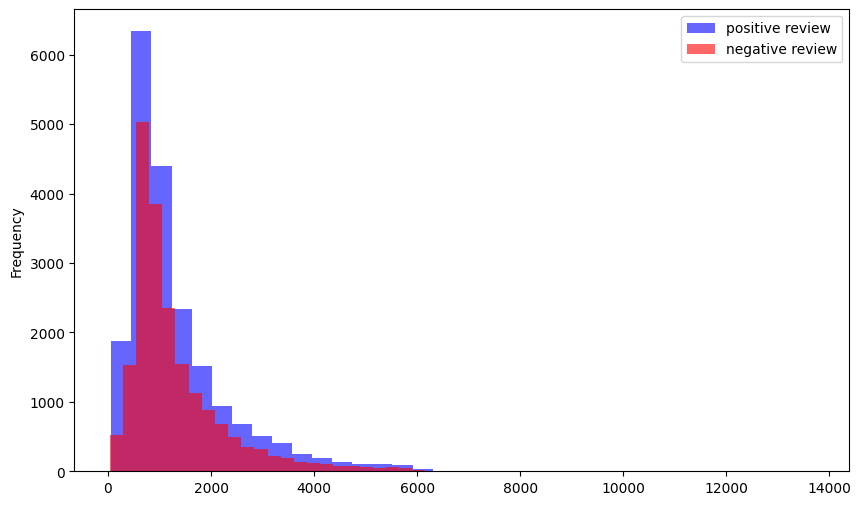

<Axes: xlabel='label', ylabel='count'>

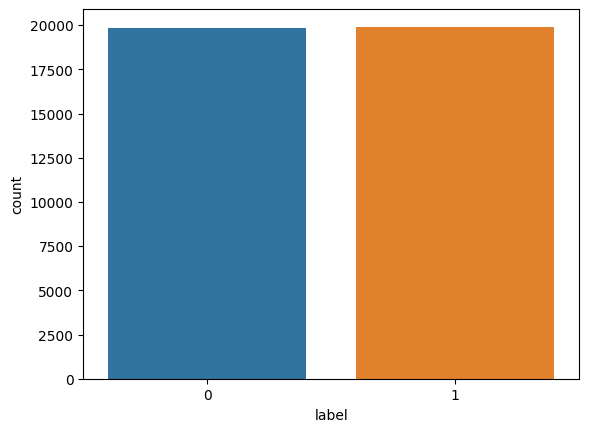

In [11]:
#sentiment vs Length
plt.figure(figsize=(10,6))
data[data['label']==1]['length'].plot(kind='hist',color='blue',label='positive review',alpha=0.6,bins=35)
data[data['label']==0]['length'].plot(kind='hist',color='red',label='negative review',alpha=0.6,bins=35)

plt.legend()

plt.show()

sns.countplot(x='label',data=data)

# **Data Pre-Processing**

In [12]:
nltk.download('stopwords')
#Converting in lowercase
data['text'] = data['text'].apply(lambda x:x.lower())
#Removing Special Characters and Punctuations
def remove_sp_char(text):
  text = re.sub('[^a-zA-Z0-9\s]','',text)
  return text

data['text'] = data['text'].apply(remove_sp_char)

#Removing stopwords
stop_words = stopwords.words('english')

def remove_stopwords(text):
   words = text.split()
   filtered_words = [word for word in words if word not in stop_words]
   return ' '.join(filtered_words)

data['text'] = data['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
data['text'].head()

0    grew b 1965 watching loving thunderbirds mates...
1    put movie dvd player sat coke chips expectatio...
2    people know particular time past like feel nee...
3    even though great interest biblical movies bor...
4    im die hard dads army fan nothing ever change ...
Name: text, dtype: object

In [14]:
#Tokenisation
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])
data['text_token'] = tokenizer.texts_to_sequences(data['text'])
index_word = tokenizer.index_word
def tokens_to_words(tokens):
    return ','.join([index_word.get(token, '') for token in tokens])

data['text_tokens_words'] = data['text_token'].apply(tokens_to_words)

print(data['text_tokens_words'].head())

0    grew,b,1965,watching,loving,thunderbirds,mates...
1    put,movie,dvd,player,sat,coke,chips,expectatio...
2    people,know,particular,time,past,like,feel,nee...
3    even,though,great,interest,biblical,movies,bor...
4    im,die,hard,dads,army,fan,nothing,ever,change,...
Name: text_tokens_words, dtype: object


In [15]:
#Stemming
st = nltk.PorterStemmer ()

def stemming(text):
  words = text.split(',')
  stemmed_words = [st.stem(word) for word in words]
  return ','.join(stemmed_words)

data['Stemmed_word'] = data['text_tokens_words'].apply(stemming)

data['Stemmed_word'].head()

0    grew,b,1965,watch,love,thunderbird,mate,school...
1    put,movi,dvd,player,sat,coke,chip,expect,hope,...
2    peopl,know,particular,time,past,like,feel,need...
3    even,though,great,interest,biblic,movi,bore,de...
4    im,die,hard,dad,armi,fan,noth,ever,chang,got,t...
Name: Stemmed_word, dtype: object

In [16]:
#Lemmatization
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatization(text):
  words = text.split(',')
  lemmatized_words = [lm.lemmatize(word) for word in words]
  return ','.join(lemmatized_words)
data['Lemmatized_word'] = data['Stemmed_word'].apply(lemmatization)
data['Lemmatized_word'].head()


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    grew,b,1965,watch,love,thunderbird,mate,school...
1    put,movi,dvd,player,sat,coke,chip,expect,hope,...
2    peopl,know,particular,time,past,like,feel,need...
3    even,though,great,interest,biblic,movi,bore,de...
4    im,die,hard,dad,armi,fan,noth,ever,chang,got,t...
Name: Lemmatized_word, dtype: object

In [17]:
#Spliting in train/test
x = data['Lemmatized_word']
y = data['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

# **Feature Extraction**

In [18]:
#One hot encoding
def one_hot(x_train,x_test):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(x_train)

  x_train_onehot = tokenizer.texts_to_matrix(x_train, mode='binary')
  x_test_onehot = tokenizer.texts_to_matrix(x_test, mode='binary')
  return x_train_onehot, x_test_onehot

In [19]:
#Bags of Words
def BoW(x_train, x_test):
  vectorizer = CountVectorizer()
  x_train_bow = vectorizer.fit_transform(x_train)
  x_test_bow = vectorizer.transform(x_test)
  return x_train_bow, x_test_bow


In [20]:
#TF - IDF Vectorizer
def TF_IDF(x_train, x_test):
  Tf_vectorizer = TfidfVectorizer()
  x_train_tfidf = Tf_vectorizer.fit_transform(x_train)
  x_test_tfidf = Tf_vectorizer.transform(x_test)
  return x_train_tfidf, x_test_tfidf


In [21]:
#Word2Vec
def word2vec(x_train, x_test):
  w2v_model = Word2Vec(x_train, vector_size=100, window=5, min_count=2, workers=4)

  def document_vector(doc, model):
      doc = [word for word in doc if word in model.wv]
      if len(doc) == 0:
          return np.zeros(model.vector_size)
      return np.mean(model.wv[doc], axis=0)

  x_train_w2v = np.array([document_vector(doc, w2v_model) for doc in x_train])
  x_test_w2v  = np.array([document_vector(doc, w2v_model) for doc in x_test])
  return x_train_w2v, x_test_w2v


In [22]:
# import pickle

# from scipy.sparse import save_npz

# y_train.to_pickle("y_train.pkl")
# y_test.to_pickle("y_test.pkl")

# # Save sparse matrices
# np.save("x_train_onehot.npy", x_train_onehot)
# np.save("x_test_onehot.npy", x_test_onehot)
# np.save("x_train_bow.npy", x_train_bow)
# np.save("x_test_bow.npy", x_test_bow)
# np.save("x_train_tfidf.npy", x_train_tfidf)
# np.save("x_test_tfidf.npy", x_test_tfidf)

# # Save numpy arrays
# np.save("x_train_w2v.npy", x_train_w2v)
# np.save("x_test_w2v.npy", x_test_w2v)

# **Evaluation Model**

In [23]:
def evaluate_model(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.show()




# **Model Selection**

In [35]:
embedding_functions = {
    'BoW': BoW,
    'TF-IDF': TF_IDF,
    'Word2Vec': word2vec
}

In [36]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": BernoulliNB(),
    "SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier()
}


===== Logistic Regression with BoW =====


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8765261170547514
ROC AUC Score: 0.876569746522493
F1 Score: 0.8771754100413172
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88      3991
           1       0.87      0.89      0.88      3954

    accuracy                           0.88      7945
   macro avg       0.88      0.88      0.88      7945
weighted avg       0.88      0.88      0.88      7945



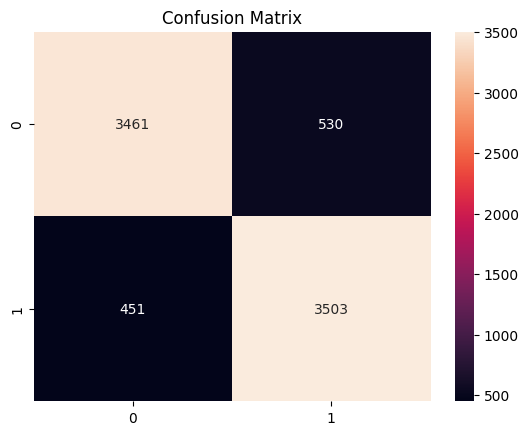


===== Naive Bayes with BoW =====
Accuracy: 0.8495909376966646
ROC AUC Score: 0.8494909575883117
F1 Score: 0.8456670541133927
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      3991
           1       0.86      0.83      0.85      3954

    accuracy                           0.85      7945
   macro avg       0.85      0.85      0.85      7945
weighted avg       0.85      0.85      0.85      7945



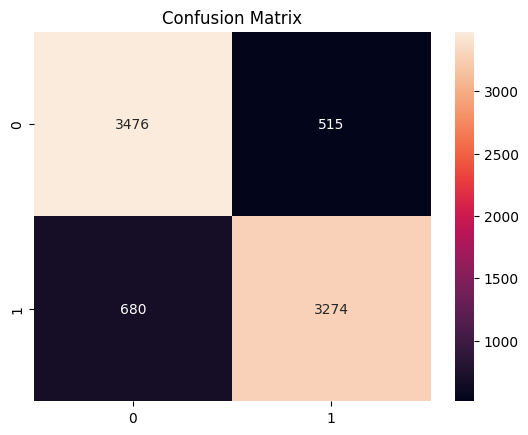


===== SVM with BoW =====


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.8601636249213341
ROC AUC Score: 0.8601975208001514
F1 Score: 0.8606197465813574
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      3991
           1       0.85      0.87      0.86      3954

    accuracy                           0.86      7945
   macro avg       0.86      0.86      0.86      7945
weighted avg       0.86      0.86      0.86      7945



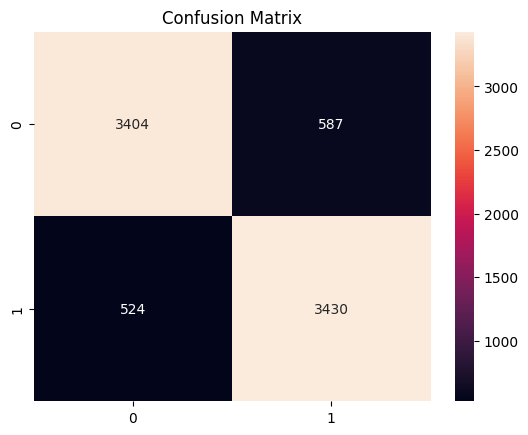


===== Random Forest with BoW =====
Accuracy: 0.8534927627438641
ROC AUC Score: 0.85349192993289
F1 Score: 0.852881698685541
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      3991
           1       0.85      0.85      0.85      3954

    accuracy                           0.85      7945
   macro avg       0.85      0.85      0.85      7945
weighted avg       0.85      0.85      0.85      7945



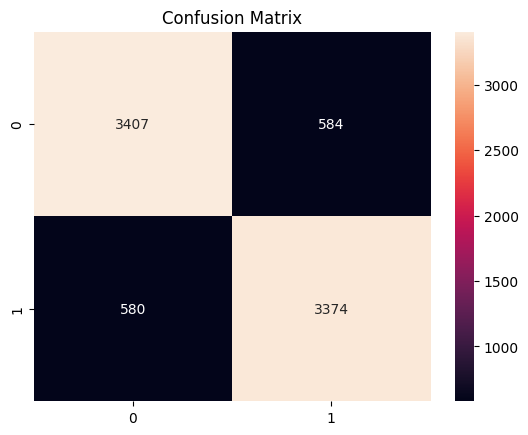


===== Logistic Regression with TF-IDF =====
Accuracy: 0.8867212083071114
ROC AUC Score: 0.8867855748271243
F1 Score: 0.8878085265519821
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.89      3991
           1       0.88      0.90      0.89      3954

    accuracy                           0.89      7945
   macro avg       0.89      0.89      0.89      7945
weighted avg       0.89      0.89      0.89      7945



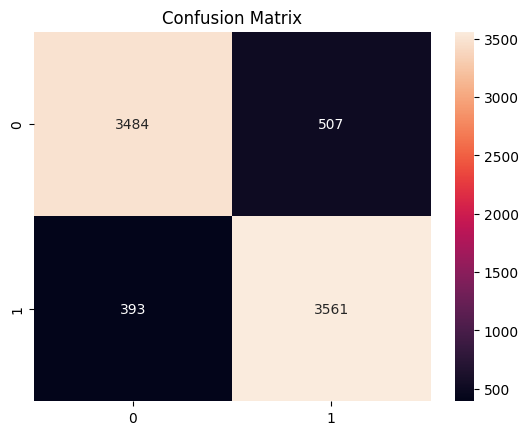


===== Naive Bayes with TF-IDF =====
Accuracy: 0.8495909376966646
ROC AUC Score: 0.8494909575883117
F1 Score: 0.8456670541133927
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      3991
           1       0.86      0.83      0.85      3954

    accuracy                           0.85      7945
   macro avg       0.85      0.85      0.85      7945
weighted avg       0.85      0.85      0.85      7945



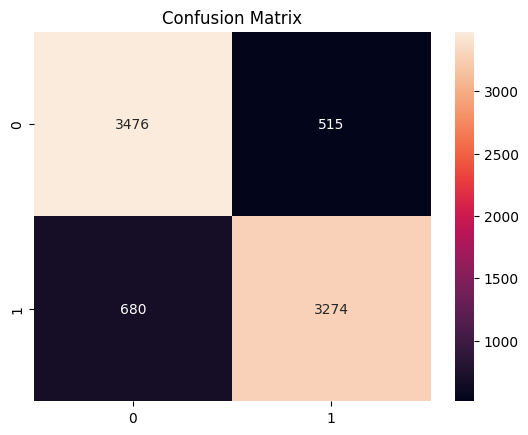


===== SVM with TF-IDF =====
Accuracy: 0.8879798615481435
ROC AUC Score: 0.8880278426155359
F1 Score: 0.8886664998749061
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      3991
           1       0.88      0.90      0.89      3954

    accuracy                           0.89      7945
   macro avg       0.89      0.89      0.89      7945
weighted avg       0.89      0.89      0.89      7945



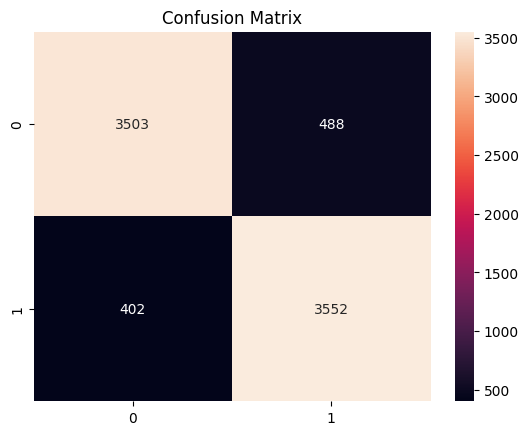


===== Random Forest with TF-IDF =====
Accuracy: 0.8465701699181876
ROC AUC Score: 0.8465111561711879
F1 Score: 0.8439779854089339
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      3991
           1       0.85      0.83      0.84      3954

    accuracy                           0.85      7945
   macro avg       0.85      0.85      0.85      7945
weighted avg       0.85      0.85      0.85      7945



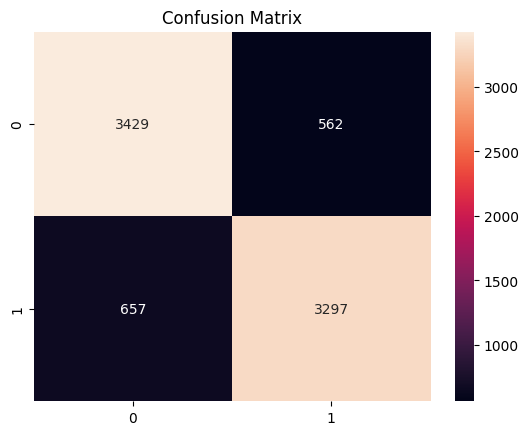


===== Logistic Regression with Word2Vec =====
Accuracy: 0.6242920075519195
ROC AUC Score: 0.6244016791954887
F1 Score: 0.631890492045875
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.60      0.62      3991
           1       0.62      0.65      0.63      3954

    accuracy                           0.62      7945
   macro avg       0.62      0.62      0.62      7945
weighted avg       0.62      0.62      0.62      7945



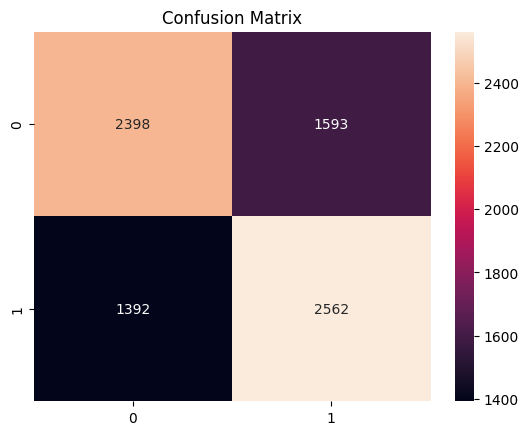


===== Naive Bayes with Word2Vec =====
Accuracy: 0.5814977973568282
ROC AUC Score: 0.5814447580399348
F1 Score: 0.5755138516532619
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.59      0.59      3991
           1       0.58      0.57      0.58      3954

    accuracy                           0.58      7945
   macro avg       0.58      0.58      0.58      7945
weighted avg       0.58      0.58      0.58      7945



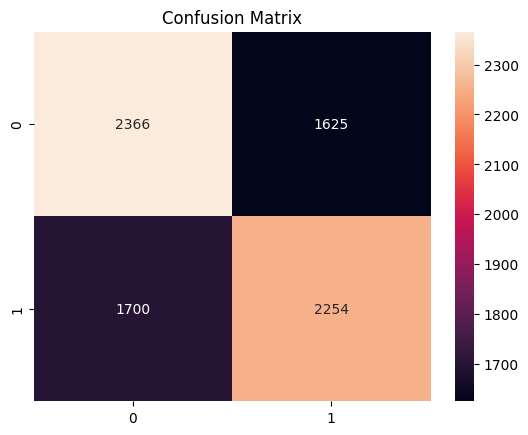


===== SVM with Word2Vec =====
Accuracy: 0.6315921963499056
ROC AUC Score: 0.631687958250018
F1 Score: 0.6379715522572665
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.61      0.62      3991
           1       0.62      0.65      0.64      3954

    accuracy                           0.63      7945
   macro avg       0.63      0.63      0.63      7945
weighted avg       0.63      0.63      0.63      7945



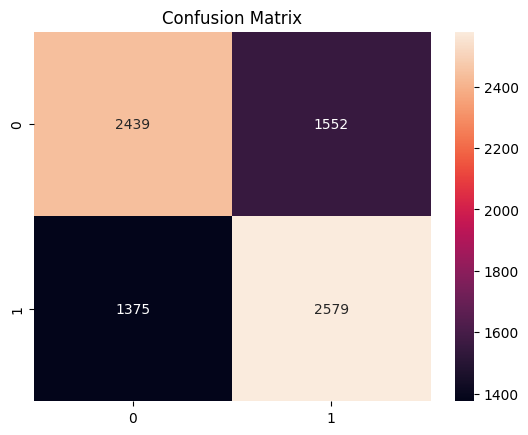


===== Random Forest with Word2Vec =====
Accuracy: 0.6125865324103209
ROC AUC Score: 0.6125839917761347
F1 Score: 0.6112654710785551
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.61      0.61      3991
           1       0.61      0.61      0.61      3954

    accuracy                           0.61      7945
   macro avg       0.61      0.61      0.61      7945
weighted avg       0.61      0.61      0.61      7945



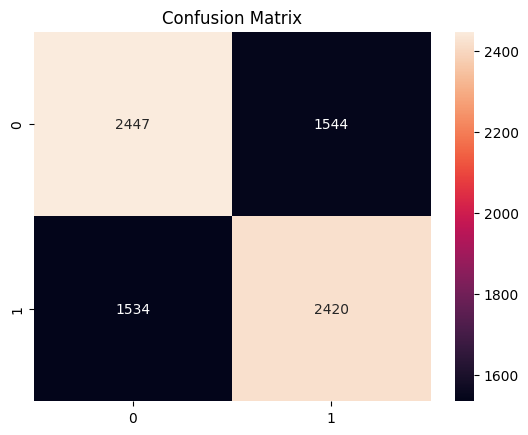

In [37]:
for embedding, funct in embedding_functions.items():
  x_train_embeding, x_test_embeding = funct(x_train, x_test)
  for model_name, model in models.items():
    print(f"\n===== {model_name} with {embedding} =====")
    evaluate_model(model,x_train_embeding,x_test_embeding,y_train,y_test)